## Document Classification using NLP, Machine Learning
### Objective
Perform document classification into four defined categories (World, Sports, Business, Sci/Tech). Compare the classifier accuracy with different models ranging from Naïve Bayes to Convolutional Neural Network (CNN) and RCNN. By making use of different feature engineering techniques and extra Natural Language Processing (NLP) features create an accurate text classifier.


In [3]:
!pip install --upgrade keras tensorflow
import pandas, numpy, string, textblob
import pickle
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, decomposition, ensemble
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import xgboost
from keras import layers, models, optimizers
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1


### Dataset
The chosen dataset is the ‘AG News’ dataset consisting of 1,20,000 news articles for training categorized in four categories- World, Sports, Business, Sci/Tech. It also includes 7600 testing samples in csv format. I have used pandas library to load the dataset.

In [8]:
#Load training data
df_train = pandas.read_csv('train.csv')
# df_train = df_train.truncate(after=10000)
#Load testing data
df_test = pandas.read_csv('test.csv')

In [9]:
df_train.head()
df_train.info()
df_count = df_train.groupby(['Class Index'], as_index = False).agg({'Title': 'count', 'Description': 'count'})
df_count.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


,Class Index,Title,Description
0,1,30000,30000
1,2,30000,30000
2,3,30000,30000
3,4,30000,30000


In [10]:
!pip install unidecode
import re, unidecode
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Needed only once
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text
def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text
def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result
def remove_slash_with_space(text):
    return text.replace('\\', " ")
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)
def text_lowercase(text):
    return text.lower()
def remove_whitespace(text):
    return  " ".join(text.split())
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return ' '.join(filtered_text)
def stem_words(text):
    stemmer = PorterStemmer()
    word_tokens = word_tokenize(text)
    stems = [stemmer.stem(word) for word in word_tokens]
    return ' '.join(stems)
def lemmatize_words(text):
    lemmatizer = WordNetLemmatizer()
    word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in word_tokens]
    return ' '.join(lemmas)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 17.2 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [11]:
# Perform preprocessing
def perform_preprocessing(text):
    text = remove_html_tags(text)
    text = remove_accented_chars(text)
    text = remove_numbers(text)
    text = remove_stopwords(text)
    text = text_lowercase(text)
    text = remove_slash_with_space(text)
    text = remove_punctuation(text)
    # text = stem_words(text)
    text = lemmatize_words(text)
    text = remove_whitespace(text)
    return text

df_train['Title'] = df_train['Title'].apply(perform_preprocessing)
df_train['Description'] = df_train['Description'].apply(perform_preprocessing)
df_test['Title'] = df_test['Title'].apply(perform_preprocessing)
df_test['Description'] = df_test['Description'].apply(perform_preprocessing)


<ipython-input-10-4ae6161fcfd8>:16: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


### Train test split

In [12]:
X_train = df_train['Description']
X_test = df_test['Description']
y_train = df_train['Class Index']
y_test = df_test['Class Index']

In [13]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(X_train)
X_train_count =  count_vect.transform(X_train)
X_test_count =  count_vect.transform(X_test)

In [14]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(X_train)
X_train_tfidf =  tfidf_vect.transform(X_train)
X_test_tfidf =  tfidf_vect.transform(X_test)

In [15]:
# ngram level tf-idf
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,2), max_features=5000)
tfidf_vect_ngram.fit(X_train)
X_train_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
X_test_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)

In [16]:
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(X_train)
X_train_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_train)
X_test_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:555: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [17]:
# label encode the target variable
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

encoder = preprocessing.LabelBinarizer()
encoder.fit(y_train)
y_train_bi = encoder.transform(y_train)
y_test_bi = encoder.transform(y_test)

###	MODEL SELECTION AND TRAINING
#### Classical models (Used as a Baseline Model)

In [18]:
def train_model(classifier, X_train, y_train, X_test, y_test, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(X_train, y_train)
    # predict the labels on validation dataset
    predictions = classifier.predict(X_test)
    return metrics.accuracy_score(predictions, y_test)

Naïve Bayes Classifier – This classification technique is based on Bayes’ Theorem and assumes independence among the predictors

![title](images/nb.png)

NB, Count Vectors:  0.8956578947368421
NB, WordLevel TF-IDF:  0.8836842105263157
NB, N-Gram Vectors:  0.8797368421052632
NB, CharLevel Vectors:  0.8444736842105263


<BarContainer object of 4 artists>

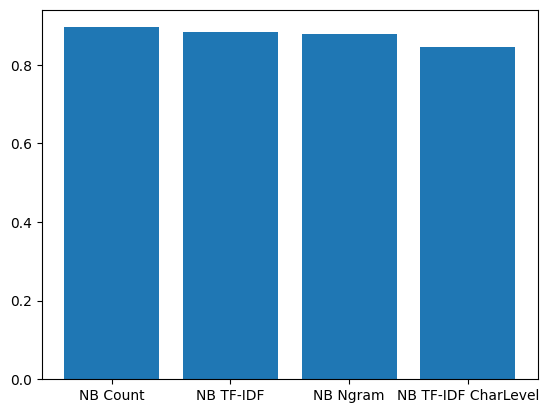

In [ ]:
# Naive Bayes on Count Vectors
accuracy1 = train_model(naive_bayes.MultinomialNB(), X_train_count, y_train, X_test_count, y_test)
print("NB, Count Vectors: ", accuracy1)

# Naive Bayes on Word Level TF IDF Vectors
accuracy2 = train_model(naive_bayes.MultinomialNB(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("NB, WordLevel TF-IDF: ", accuracy2)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy3 = train_model(naive_bayes.MultinomialNB(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram, y_test)
print("NB, N-Gram Vectors: ", accuracy3)

# Naive Bayes on Character Level TF IDF Vectors
accuracy4 = train_model(naive_bayes.MultinomialNB(), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars, y_test)
print("NB, CharLevel Vectors: ", accuracy4)

df = {'ModelType': ['NB Count', 'NB TF-IDF','NB Ngram', 'NB TF-IDF CharLevel' ], 'Accuracy': [accuracy1,accuracy2, accuracy3,accuracy4]}
df = pandas.DataFrame(df) #
plt.bar(df['ModelType'], df['Accuracy'])

Logistic Regression – This model uses a logistic/sigmoid function to calculate the probabilities of different values of the categorical dependent variable in presence of one or more predictors. Logit function is an estimation of log of odds in the favor of event and outputs a s-shaped curve with probability estimates.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR, Count Vectors:  0.8990789473684211


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR, WordLevel TF-IDF:  0.8981578947368422


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR, N-Gram Vectors:  0.8975
LR, CharLevel Vectors:  0.8819736842105264


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<BarContainer object of 4 artists>

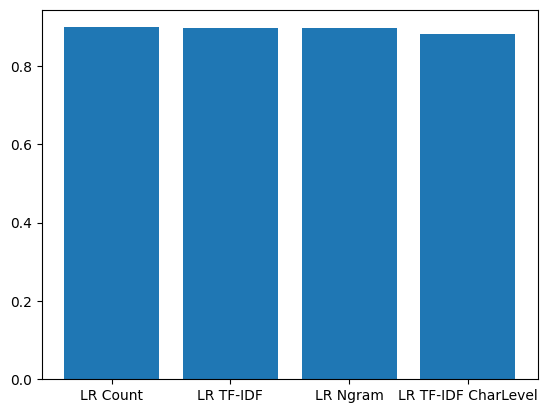

In [ ]:
# Logistic Regression on Count Vectors
accuracy1 = train_model(linear_model.LogisticRegression(), X_train_count, y_train, X_test_count, y_test)
print("LR, Count Vectors: ", accuracy1)

# Logistic Regression on Word Level TF IDF Vectors
accuracy2 = train_model(linear_model.LogisticRegression(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("LR, WordLevel TF-IDF: ", accuracy2)

# Logistic Regression on Ngram Level TF IDF Vectors
accuracy3 = train_model(linear_model.LogisticRegression(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram, y_test)
print("LR, N-Gram Vectors: ", accuracy3)

# Logistic Regression on Character Level TF IDF Vectors
accuracy4 = train_model(linear_model.LogisticRegression(), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars, y_test)
print("LR, CharLevel Vectors: ", accuracy4)

df = {'ModelType': ['LR Count', 'LR TF-IDF','LR Ngram', 'LR TF-IDF CharLevel' ], 'Accuracy': [accuracy1,accuracy2, accuracy3,accuracy4]}
df = pandas.DataFrame(df) #
plt.bar(df['ModelType'], df['Accuracy'])

Bagging Model (Random Forest) - Random Forest models are a type of ensemble models, particularly bagging models. The main aim of these models is to reduce the overfitting. They work towards reducing the model complexity.

In [ ]:
# RF on Count Vectors
accuracy1 = train_model(ensemble.RandomForestClassifier(), X_train_count, y_train, X_test_count, y_test)
print("RF, Count Vectors: ", accuracy1)

# RF on Word Level TF IDF Vectors
accuracy2 = train_model(ensemble.RandomForestClassifier(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("RF, WordLevel TF-IDF: ", accuracy2)

RF, Count Vectors:  0.8880263157894737
RF, WordLevel TF-IDF:  0.8747368421052631


XG Boost - Boosting models are type of ensemble models and work to improve the model prediction rates. This model is meta-algorithm for reducing bias and variance in supervised learning. One of its strong points is that it converts weak learner i.e. classifiers slightly correlated to the true classification into stronger ones.

Xgb, Count Vectors:  0.88
Xgb, WordLevel TF-IDF:  0.8819736842105264


<BarContainer object of 4 artists>

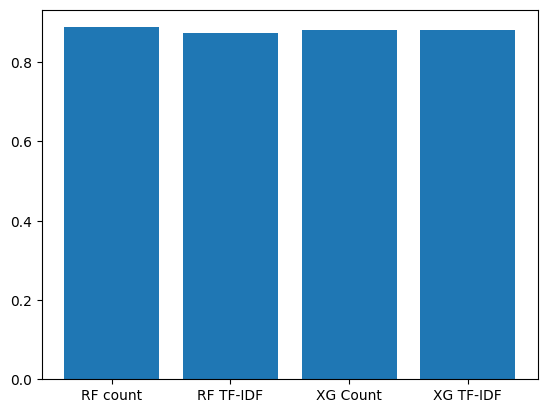

In [ ]:
# Extereme Gradient Boosting (XG boost) on Count Vectors
accuracy3 = train_model(xgboost.XGBClassifier(), X_train_count.tocsc(), y_train, X_test_count.tocsc(), y_test)
print("Xgb, Count Vectors: ", accuracy3)

# Extereme Gradient Boosting on Word Level TF IDF Vectors
accurac4 = train_model(xgboost.XGBClassifier(), X_train_tfidf.tocsc(), y_train, X_test_tfidf.tocsc(), y_test)
print("Xgb, WordLevel TF-IDF: ", accuracy4)

# # Extereme Gradient Boosting on Character Level TF IDF Vectors
# accuracy = train_model(xgboost.XGBClassifier(), X_train_tfidf_ngram_chars.tocsc(), y_train, X_test_tfidf_ngram_chars.tocsc(), y_test)
# print("Xgb, CharLevel Vectors: ", accuracy)
df = {'ModelType': ['RF count', 'RF TF-IDF','XG Count', 'XG TF-IDF' ], 'Accuracy': [accuracy1,accuracy2, accuracy3,accuracy4]}
df = pandas.DataFrame(df) #
plt.bar(df['ModelType'], df['Accuracy'])

To further improve the performance of the model and studying the recent advancement in NLP, I used the following Neural network models for the problem statement-
### Shallow Neural Network


In [ ]:
plt.style.use('ggplot')
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 219s 200ms/step - accuracy: 0.8616 - loss: 0.4986 - val_accuracy: 0.8939 - val_loss: 0.2930
Epoch 2/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 69s 23ms/step - accuracy: 0.9181 - loss: 0.2331 - val_accuracy: 0.8967 - val_loss: 0.2919
Epoch 3/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.9347 - loss: 0.1868 - val_accuracy: 0.8956 - val_loss: 0.3112
Epoch 4/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9500 - loss: 0.1449 - val_accuracy: 0.8917 - val_loss: 0.3364
Epoch 5/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9659 - loss: 0.1041 - val_accuracy: 0.8907 - val_loss: 0.3791
Epoch 6/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9791 - loss: 0.0694 - val_accuracy: 0.8876 - val_loss: 0.4295
Epoch 7/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.9878 - loss: 0.0427 - val_accuracy: 0.8857 - val_loss: 0.4795
Epoch 8/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9920 - loss:

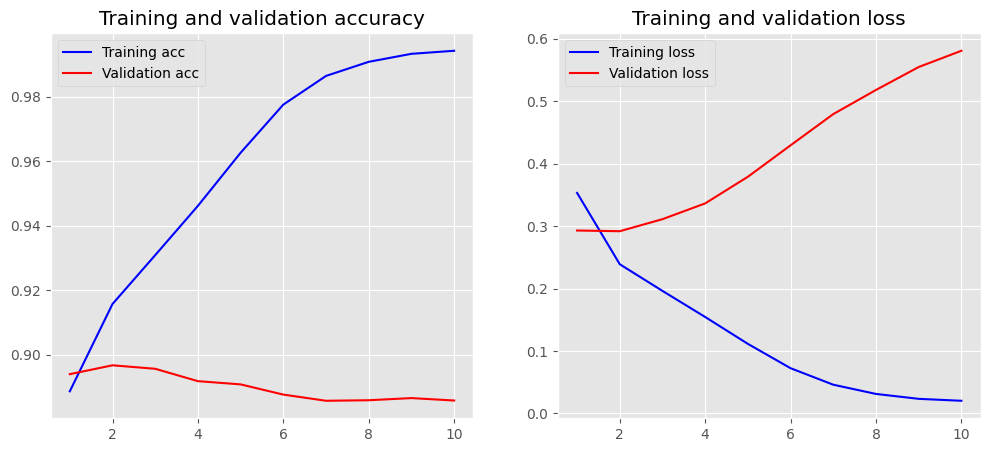

In [ ]:
vocab_size = X_train_tfidf.shape[1]
num_labels = 4
batch_size = 100
# Neural network on TFIDF
model = models.Sequential()
model.add(layers.Dense(512, input_shape=(vocab_size,)))
model.add(layers.Activation('relu'))
model.add(layers.Dense(4))
model.add(layers.Activation('softmax'))
# model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train_tfidf, y_train_bi,
                    batch_size=batch_size,
                    epochs=10,
                    validation_split=0.1,
                    verbose=1)

loss, accuracy = model.evaluate(X_train_tfidf, y_train_bi, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_tfidf, y_test_bi, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
vocab_size = 15000
num_labels = 4
batch_size = 100
maxlen = 200

tokenizer =Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding again 1 because of reserved 0 index

X_train_token = pad_sequences(X_train_token, padding='post', maxlen=maxlen)
X_test_token = pad_sequences(X_test_token, padding='post', maxlen=maxlen)
embedding_dim = 300

In [ ]:
# create embedding matrix using pre-trained word vectors
def create_embedding_matrix(filepath, word_index, embedding_dim):
    embedding_matrix = numpy.zeros((vocab_size, embedding_dim))

    with open(filepath,'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = numpy.array(
                    vector, dtype=numpy.float32)[:embedding_dim]

    return embedding_matrix

#basic new word embed
embedding_matrix = create_embedding_matrix('glove.6B.300d.txt',tokenizer.word_index, embedding_dim)
nonzero_elements = numpy.count_nonzero(numpy.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements / vocab_size)


0.7124692438528989


In [ ]:
# Shallow neural network basic with word embedding matrix
embedding_dim = 300

model = models.Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           weights=[embedding_matrix],
                           input_length=maxlen,
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(512, input_shape=(vocab_size,)))
model.add(layers.Activation('relu'))
model.add(layers.Dense(4))
model.add(layers.Activation('softmax'))
# model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train_token, y_train_bi,
                    batch_size=batch_size,
                    epochs=10,
                    validation_split=0.1,
                    verbose=1)

loss, accuracy = model.evaluate(X_train_token, y_train_bi, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_token, y_test_bi, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8216 - loss: 0.5049 - val_accuracy: 0.8986 - val_loss: 0.2871
Epoch 2/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9167 - loss: 0.2460 - val_accuracy: 0.8942 - val_loss: 0.3024
Epoch 3/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9412 - loss: 0.1728 - val_accuracy: 0.8997 - val_loss: 0.2909
Epoch 4/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9605 - loss: 0.1169 - val_accuracy: 0.8965 - val_loss: 0.3310
Epoch 5/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9737 - loss: 0.0781 - val_accuracy: 0.8908 - val_loss: 0.4008
Epoch 6/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9847 - loss: 0.0460 - val_accuracy: 0.8912 - val_loss: 0.4526
Epoch 7/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9889 - loss: 0.0342 - val_accuracy: 0.8754 - val_loss: 0.5942
Epoch 8/10
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9925 - loss: 0.0232 

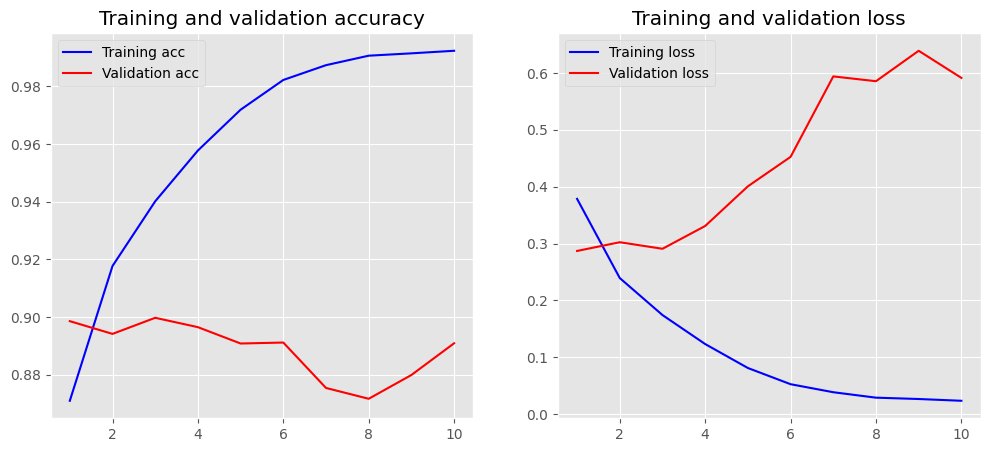

In [ ]:
plot_history(history)

### Deep neural network
I have used keras for setting up the deep neural network.

#### Convolutional Neural Network (Covnets)



In [ ]:
# Deep Neural networks CNN
model = models.Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           weights=[embedding_matrix],
                           input_length=maxlen,
                           trainable=True))
model.add(layers.SpatialDropout1D(0.3))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(256))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(4))
model.add(layers.Activation('softmax'))
# model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train_token, y_train_bi,
                    batch_size=30,
                    epochs=10,
                    validation_split=0.1,
                    verbose=1)

loss, accuracy = model.evaluate(X_train_token, y_train_bi, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_token, y_test_bi, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/10
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - accuracy: 0.8632 - loss: 0.3956 - val_accuracy: 0.9033 - val_loss: 0.2617
Epoch 2/10
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step - accuracy: 0.9223 - loss: 0.2283 - val_accuracy: 0.9117 - val_loss: 0.2561
Epoch 3/10
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.9379 - loss: 0.1743 - val_accuracy: 0.9068 - val_loss: 0.2664
Epoch 4/10
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.9520 - loss: 0.1307 - val_accuracy: 0.9070 - val_loss: 0.3166
Epoch 5/10
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.9614 - loss: 0.1028 - val_accuracy: 0.9028 - val_loss: 0.3730
Epoch 6/10
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - accuracy: 0.9699 - loss: 0.0788 - val_accuracy: 0.9013 - val_loss: 0.4156
Epoch 7/10
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - accuracy: 0.9755 - loss: 0.0667 - val_accuracy: 0.9018 - val_loss: 0.4522
Epoch 8/10
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - accuracy: 0.9787 - loss: 0

#### Recurrent Neural Network Bidirectional GRU


In [ ]:
# Bi directional rnn gru

model = models.Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           weights=[embedding_matrix],
                           input_length=maxlen,
                           trainable=True))
model.add(layers.SpatialDropout1D(0.3))
model.add(layers.Bidirectional(layers.GRU(100)))
model.add(layers.Dense(512, input_shape=(vocab_size,)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(4))
model.add(layers.Activation('softmax'))
# model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train_token, y_train_bi,
                    batch_size=batch_size,
                    epochs=5,
                    validation_split=0.1,
                    verbose=1)

loss, accuracy = model.evaluate(X_train_token, y_train_bi, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_token, y_test_bi, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1080/1080 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.8422 - loss: 0.4337 - val_accuracy: 0.9101 - val_loss: 0.2494
Epoch 2/5
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 77s 42ms/step - accuracy: 0.9210 - loss: 0.2283 - val_accuracy: 0.9135 - val_loss: 0.2419
Epoch 3/5
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 82s 43ms/step - accuracy: 0.9360 - loss: 0.1809 - val_accuracy: 0.9084 - val_loss: 0.2527
Epoch 4/5
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 82s 42ms/step - accuracy: 0.9479 - loss: 0.1442 - val_accuracy: 0.9078 - val_loss: 0.2759
Epoch 5/5
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 82s 42ms/step - accuracy: 0.9587 - loss: 0.1136 - val_accuracy: 0.9090 - val_loss: 0.2959
Training Accuracy: 0.9683
Testing Accuracy:  0.9163


### Saving Model
#### Save the model as well as tokenizer.

We have to save our tokenizer because it is our vocabulary. The same tokenizer and vocabulary have to be used for accurate prediction.

In [ ]:
# creates a HDF5 file 'my_model.h5'
model.save('my_model.h5')

# Save Tokenizer i.e. Vocabulary
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Result
The model that gave me the best performance on the test data is was Bidirectional RNN gru with an accuracy of 91.63 % with 5 epochs. The model can be used to process any document and predict a class for it. Using some random news articles on the internet I found the predictions fairly correct.

### Conclusion
While the classical models provided a good accuracy the neural network models improved it further. With more data the deep learning models will outmatch classical models. Using word embedding provided an additional 2-3% improvement in accuracy and faster training time. RNN provided the best performance in neural networks but CNN still had good results.

#### Loading the best model

In [22]:
from tensorflow.keras.models import load_model #Import the load_model function from Keras
from tensorflow.keras.preprocessing import text, sequence

final_model = load_model('my_model.h5')

# load tokenizer
tokenizer = text.Tokenizer()
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

maxlen=100


In [23]:
class_dict = {'0': 'World', '1': 'Sports','2': 'Business','3': 'Sci/Tech'}
inp = ["Former opener Aakash Chopra has revealed how the relationship between Sourav Ganguly and coach John Buchanan turned strenuous at Kolkata Knight Riders, to an extent that the former Australia coach wanted to remove the ex-India skipper as the captain of the side. Chopra, who was with KKR in 2008, said Buchanan and Ganguly started off a decent note before the relationship turned frosty over time as the team finished sixth in the first season.“In the first year of IPL, there was John Buchanan [as coach], [fellow Australian] Ricky Ponting was also there. Sourav Ganguly was the captain. I have seen this from close quarters – their relationship was alright to begin with, but it worsened [with time],” Chopra said on his YouTube channel."]
inp = [perform_preprocessing(x) for x in inp]
inp_token = tokenizer.texts_to_sequences(inp)
inp_token = sequence.pad_sequences(inp_token, padding='post', maxlen=maxlen)

out = final_model.predict(inp_token)
predicted_label = numpy.argmax(out)
print("Predicted label: " + class_dict.get(str(predicted_label)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted label: Sports
